In [3]:
import pandas as pd
import tensorflow as tf
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import os
from tqdm import tqdm
keras = tf.keras
import cv2

2024-02-21 18:39:45.953854: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0


In [4]:
dir_img = '/home/riccardo/PycharmProjects/Test1/data/Grains'
dir_mask = '/home/riccardo/PycharmProjects/Test1/data/Segmented'
list_img = sorted(os.listdir(dir_img))


In [5]:
list_img_path = []
for i in list_img:
    list_img_path.append(os.path.join(dir_img,i))

In [6]:
list_mask_path = []
for i in sorted(os.listdir(dir_mask)):
    list_mask_path.append(os.path.join(dir_mask,i))

In [7]:
list_img_load = []
for i in tqdm(list_img_path):
    img = plt.imread(i)
    list_img_load.append(img)

100%|██████████| 336/336 [00:01<00:00, 198.07it/s]


In [8]:
list_mask_load = []
for i in tqdm(list_mask_path):
    img = plt.imread(i)
    list_mask_load.append(img)

100%|██████████| 336/336 [00:00<00:00, 1211.45it/s]


In [9]:
split = int(len(list_img_load)*0.75)

In [10]:
list_mask_load = np.array(list_mask_load)/255
list_mask_load = np.where(list_mask_load > 0.5, 1, 0)
list_img_load = np.array(list_img_load)

In [11]:
from tensorflow.keras.models import load_model

model = load_model('Models/test_grain_py39_tf250.h5')

2024-02-21 18:39:59.011412: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcuda.so.1
2024-02-21 18:39:59.048596: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-02-21 18:39:59.048758: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1733] Found device 0 with properties: 
pciBusID: 0000:01:00.0 name: NVIDIA GeForce GTX 1060 6GB computeCapability: 6.1
coreClock: 1.7335GHz coreCount: 10 deviceMemorySize: 5.93GiB deviceMemoryBandwidth: 178.99GiB/s
2024-02-21 18:39:59.048793: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0
2024-02-21 18:39:59.051677: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcublas.so.11
2024-02-21 18:39:59.051788: I tensorflow/stream_executo

In [12]:
test = model.predict(list_img_load[0].reshape(1,300,400,3))

2024-02-21 18:39:59.694055: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:176] None of the MLIR Optimization Passes are enabled (registered 2)
2024-02-21 18:39:59.713276: I tensorflow/core/platform/profile_utils/cpu_utils.cc:114] CPU Frequency: 3399905000 Hz
2024-02-21 18:39:59.787319: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudnn.so.8
2024-02-21 18:40:00.037637: I tensorflow/stream_executor/cuda/cuda_dnn.cc:359] Loaded cuDNN version 8906
2024-02-21 18:40:00.179675: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcublas.so.11
2024-02-21 18:40:00.179924: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcublasLt.so.11


(300, 400, 1)


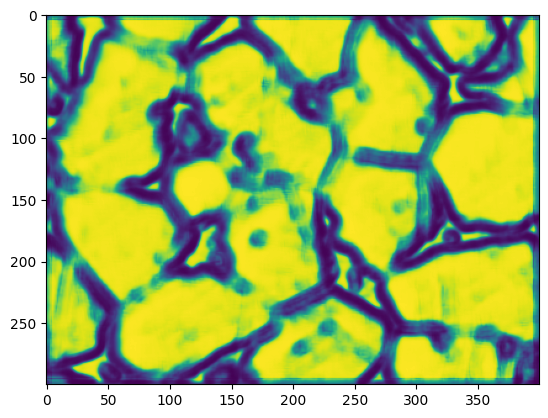

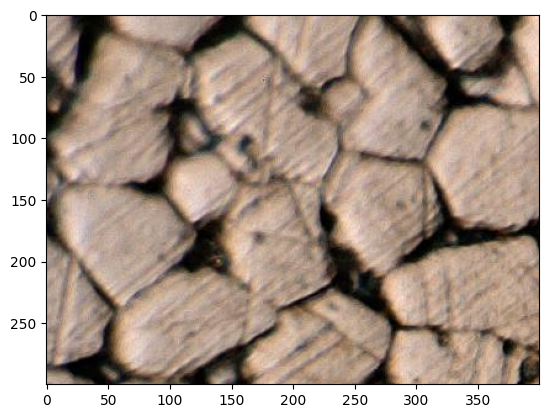

In [38]:
test = test.reshape(-1,400,1)
print(test.shape)
plt.imshow(test)
plt.show()
plt.imshow(list_img_load[0])

In [14]:
CV2_img_canny_load = []
for i in list_img_path[:10]:
    img = cv2.imread(i)
    canny_edge = cv2.Canny(img,50,150)
    CV2_img_canny_load.append(canny_edge)

In [15]:
class CropLayer(object):
    def __init__(self, params, blobs):
        # initialize our starting and ending (x, y)-coordinates of
        # the crop
        self.startX = 0
        self.startY = 0
        self.endX = 0
        self.endY = 0

    def getMemoryShapes(self, inputs):
        # the crop layer will receive two inputs -- we need to crop
        # the first input blob to match the shape of the second one,
        # keeping the batch size and number of channels
        (inputShape, targetShape) = (inputs[0], inputs[1])
        (batchSize, numChannels) = (inputShape[0], inputShape[1])
        (H, W) = (targetShape[2], targetShape[3])

        # compute the starting and ending crop coordinates
        self.startX = int((inputShape[3] - targetShape[3]) / 2)
        self.startY = int((inputShape[2] - targetShape[2]) / 2)
        self.endX = self.startX + W
        self.endY = self.startY + H 

        # return the shape of the volume (we'll perform the actual
        # crop during the forward pass
        return [[batchSize, numChannels, H, W]]

    def forward(self, inputs):
        # use the derived (x, y)-coordinates to perform the crop
        return [inputs[0][:, :, self.startY:self.endY,
                self.startX:self.endX]]

In [16]:
protoPath = "Training_cafe_model_opencv/deploy.prototxt"
modelPath = "Training_cafe_model_opencv/hed_pretrained_bsds.caffemodel"
net = cv2.dnn.readNetFromCaffe(protoPath, modelPath)
cv2.dnn_registerLayer("Crop", CropLayer)

In [17]:
CV2_img_norm_load = []
for i in list_img_path[:10]:
    img = cv2.imread(i)
    (H, W) = img.shape[:2]
    mean_pixel_values= np.average(img, axis = (0,1))
    blob = cv2.dnn.blobFromImage(img, scalefactor=0.7, size=(W, H),
                             mean=(mean_pixel_values[0], mean_pixel_values[1], mean_pixel_values[2]),
                             swapRB= False, crop=False)
    blob_for_plot = np.moveaxis(blob[0,:,:,:], 0,2)
    net.setInput(blob)
    hed = net.forward()
    hed = hed[0,0,:,:]  #Drop the other axes 
#hed = cv2.resize(hed[0, 0], (W, H))
    hed = (255 * hed).astype("uint8")  #rescale to 0-255
    CV2_img_norm_load.append(hed)

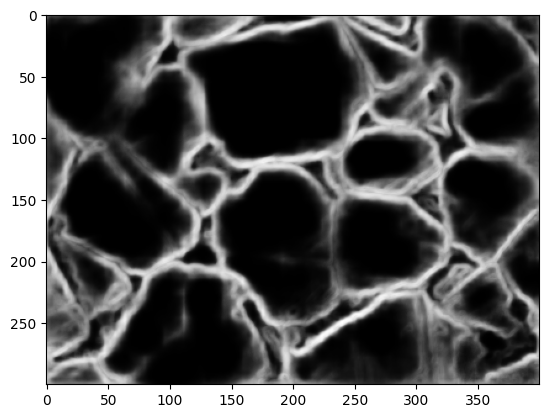

In [18]:
plt.imshow(CV2_img_norm_load[1], cmap='gray')

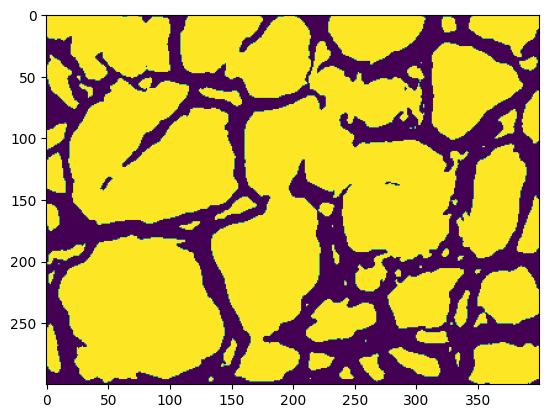

In [52]:
blur = cv2.GaussianBlur(hed, (3,3), 0)
thresh = cv2.threshold(blur, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)[1]
plt.imshow(thresh)

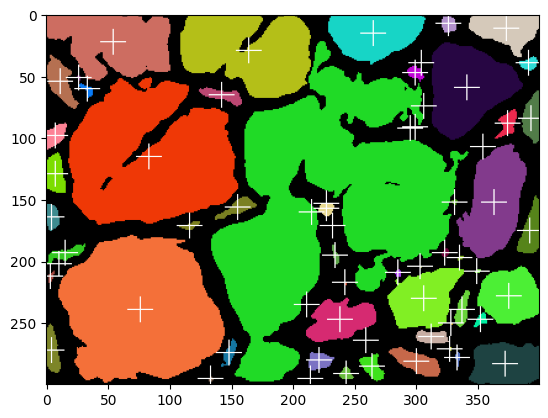

In [20]:
n_labels, labels, stats, centroids = cv2.connectedComponentsWithStats(thresh, connectivity=4)
# Create false color image with black background and colored objects
colors = np.random.randint(0, 255, size=(n_labels, 3), dtype=np.uint8)
colors[0] = [0, 0, 0]  # black background
false_colors = colors[labels]

# Obtain centroids
false_colors_centroid = false_colors.copy()
for centroid in centroids:
    cv2.drawMarker(false_colors_centroid, (int(centroid[0]), int(centroid[1])),
                   color=(255, 255, 255), markerType=cv2.MARKER_CROSS)
plt.imshow(false_colors_centroid)


In [21]:
# Remove small objects
MIN_AREA = 50
false_colors_area_filtered = false_colors.copy()
for i, centroid in enumerate(centroids[1:], start=1):
    area = stats[i, 4]
    if area > MIN_AREA:
        cv2.drawMarker(false_colors_area_filtered, (int(centroid[0]), int(centroid[1])),
                       color=(255, 255, 255), markerType=cv2.MARKER_CROSS)

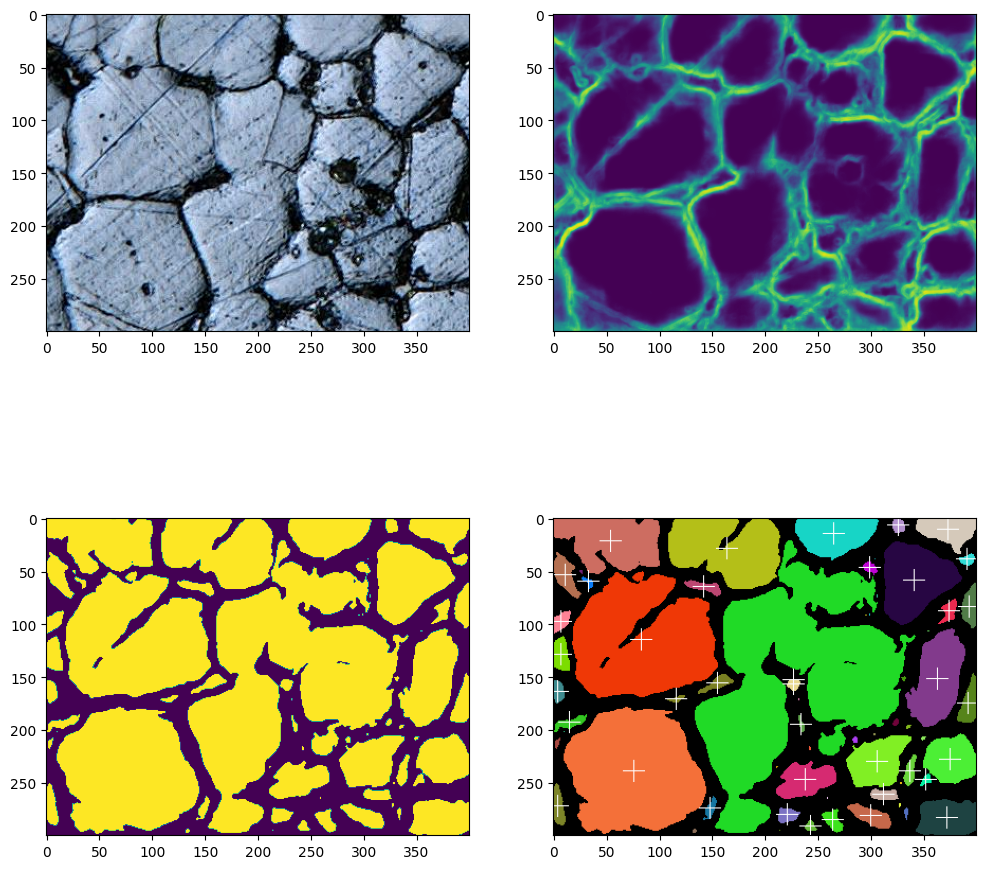

In [22]:
plt.figure(figsize=(12, 12))
plt.subplot(221)
plt.imshow(img)
plt.subplot(222)
plt.imshow(hed)
plt.subplot(223)
plt.imshow(thresh)
plt.subplot(224)
plt.imshow(false_colors_area_filtered) 
plt.show()

In [23]:
from skimage import measure
props = measure.regionprops_table(labels, intensity_image=img, 
                              properties=['label',
                                          'area', 'equivalent_diameter',
                                          'mean_intensity', 'solidity'])
    
import pandas as pd
df = pd.DataFrame(props)

#Filter by size
df = df[df.area > 50]
df = df[df.area < 10000]

print(df.head())

   label    area  equivalent_diameter  mean_intensity-0  mean_intensity-1  \
0      1  4026.0            71.596525        137.529806        157.774466   
1      2  5464.0            83.408518        141.011530        162.157211   
2      3  2343.0            54.618680        156.675203        175.188220   
3      4  1260.0            40.053487        153.384921        171.085714   
4      5   132.0            12.964090          9.219697         12.803030   

   mean_intensity-2  solidity  
0        183.298063  0.879231  
1        188.166179  0.883999  
2        201.888604  0.970588  
3        195.505556  0.895522  
4         13.583333  0.942857  


In [24]:
len(df['label'])

36

In [82]:
image_uint8 = (test.reshape(-1, 400) * 255).astype(np.uint8)

thresh2 = cv2.threshold(image_uint8, 230, 255, cv2.THRESH_BINARY)[1]

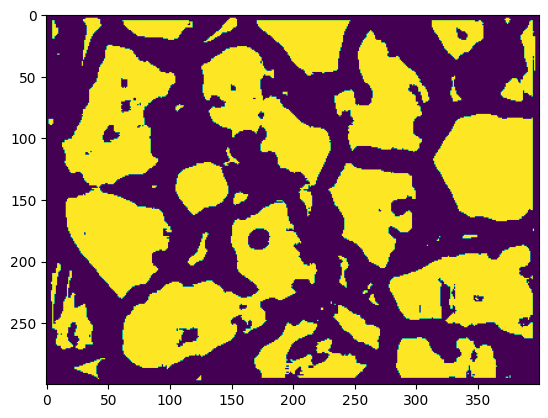

In [83]:
plt.imshow(thresh2)

55


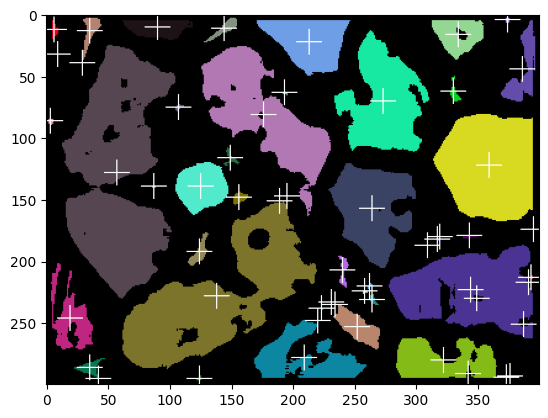

In [87]:
n_labels, labels, stats, centroids = cv2.connectedComponentsWithStats(thresh2, connectivity=4)
# Create false color image with black background and colored objects
colors = np.random.randint(0, 255, size=(n_labels, 3), dtype=np.uint8)
colors[0] = [0, 0, 0]  # black background
false_colors = colors[labels]

# Obtain centroids
false_colors_centroid = false_colors.copy()
for centroid in centroids:
    cv2.drawMarker(false_colors_centroid, (int(centroid[0]), int(centroid[1])),
                   color=(255, 255, 255), markerType=cv2.MARKER_CROSS)
plt.imshow(false_colors_centroid)
print(n_labels)

In [88]:
MIN_AREA = 50
false_colors_area_filtered = false_colors.copy()
for i, centroid in enumerate(centroids[1:], start=1):
    area = stats[i, 4]
    if area > MIN_AREA:
        cv2.drawMarker(false_colors_area_filtered, (int(centroid[0]), int(centroid[1])),
                       color=(255, 255, 255), markerType=cv2.MARKER_CROSS)

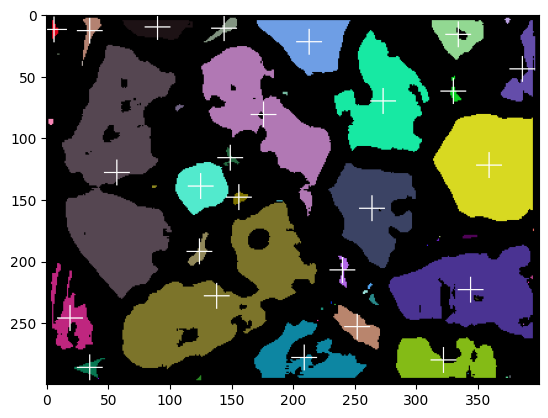

In [89]:
plt.imshow(false_colors_area_filtered)

In [93]:
# Compter le nombre d'objets avec une aire supérieure à MIN_AREA
filtered_object_count = sum([1 for i in range(1, n_labels) if stats[i, cv2.CC_STAT_AREA] > MIN_AREA])
print(filtered_object_count)


25
